In [1]:
from network import *
from networkFlow import *
from FiniteDiff import *
from PDEq import *
from support import *

from time import time

import autograd.numpy as anp
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from autograd import grad, elementwise_grad
from sklearn.metrics import r2_score

## Random seed
default_seed = 15; anp.random.seed(default_seed)

## Figure defaults
plt.rcParams["figure.figsize"] = (5,5); plt.rcParams["font.size"] = 10

2024-12-10 19:36:54.658492: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 19:36:54.669839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733855814.683097  171692 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733855814.686685  171692 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 19:36:54.701256: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Problem setup

In [2]:
## Differential equations
test_cases = ['diff1d','wave1d','wave2d','diff2d']
test = test_cases[3]

## Coefficients
c,D,amplitude = 1.,1.,1.

if test == 'diff1d':
    PDE = Diffusion1D(sim_type='flow',amp=amplitude,D=D)
    t0,tN,x0,xN = 0,1,0,1
elif test == 'wave1d':
    PDE = Wave1D(sim_type='flow',amp=amplitude,c=c)
    t0,tN,x0,xN = 0,1,-1,1
elif test == 'wave2d':
    PDE = Wave2D(sim_type='flow',amp=amplitude,c=c)
    t0,tN = 0,1
    x0,xN,y0,yN = -1,1,-1,1
elif test == 'diff2d':
    PDE = Diffusion2D(sim_type='flow',amp=amplitude,D=D)
    t0,tN = 0,1
    x0,xN,y0,yN = 0,1,0,1

## Defining the source function (necessary?)
f = PDE.right_hand_side

## Domain setup
Nt,Nx,Ny = 100,100,100

t_bound = [t0,tN]
x_bound = [x0,xN]


t = np.linspace(t_bound[0],t_bound[1],Nt)
x = np.linspace(x_bound[0],x_bound[1],Nx)

if test == 'wave2d' or test == 'diff2d':
    y_bound = [y0,yN]
    y = np.linspace(y_bound[0],y_bound[1],Ny)
    domain_array = np.array([t,x,y])
else:
    domain_array = np.array([t,x])

2024-12-10 19:36:56.618141: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Prediction with `ADAM`

In [13]:
## Layer configuration
#layer_out_sizes = [20,20,20,20,20,20,20,20,1]
#layer_out_sizes = [20,20,20,1]
layer_out_sizes = [100,100,1]


## Activation functions
hidden_func = 'swish' # sigmoid, relu, elu, leaky_relu, tanh, swish, gelu, hard_sigmoid, exponential

act_funcs = []
for i in range(len(layer_out_sizes)-1):
    act_funcs.append(hidden_func)

## Output layer activation function set to identity
act_funcs.append(None); 

## Gradient descent method, regularizer and learning rate
lmbda = 1e-8
gd_method = 'adam'
eta = 1e-2 # None
epoch = 1000

## Collocation tensor parameters
c_points = 10000; b_points = 100; i_points = 100

## Network initializtion
if test == 'wave2d' or test == 'diff2d':
    TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

    ## Setup of collocation tensor
    TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
else:
    TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

    ## Setup of collocation tensor
    TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)
TFNetwork.create_layers(lmbda=lmbda)

epoch = epoch

tf_net_timer = [time()]
TFNetwork.train_network(epochs=epoch,tol=1e-8)
tf_net_timer.append(time())

print('TensorFlow PINN-solver time: %.2f sec.' %(tf_net_timer[1]-tf_net_timer[0]))

Final cost = 1.87724e-02
TensorFlow PINN-solver time: 154.94 sec.


Final cost: 1.87724e-02
Best cost : 1.85667e-02
0.1208286


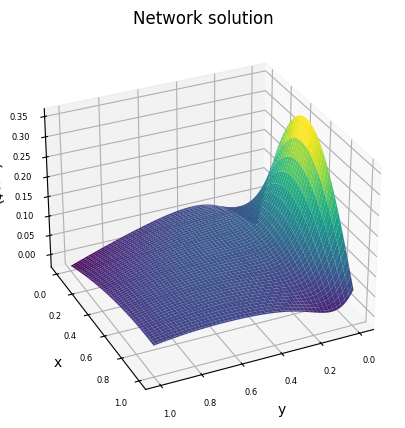

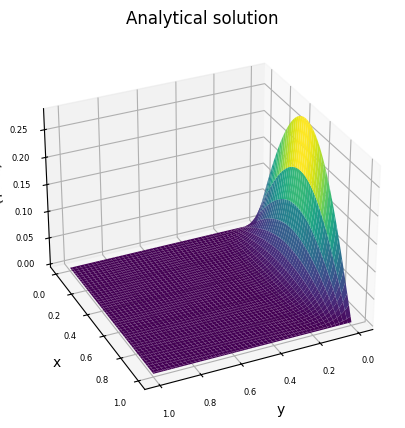

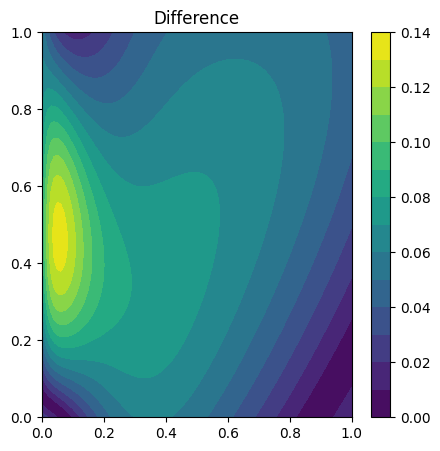

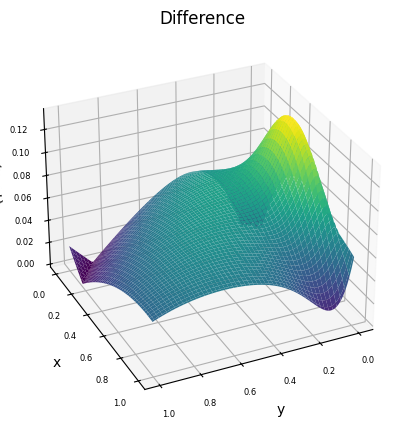

In [21]:
TFNetwork.plot_results(plots='all',time_idx=[-10])

print('Final cost: %.5e' %TFNetwork.cost_history[-1])
print('Best cost : %.5e' %min(TFNetwork.cost_history))
print(TFNetwork.abs_diff.mean())

### Prediction with `RMSprop`

In [8]:
gd_method = 'rmsprop'

## Network initializtion
if test == 'wave2d' or test == 'diff2d':
    TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

    ## Setup of collocation tensor
    TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
else:
    TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

    ## Setup of collocation tensor
    TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)
TFNetwork.create_layers(lmbda=lmbda)

epoch = epoch

tf_net_timer = [time()]
TFNetwork.train_network(epochs=epoch,tol=1e-8)
tf_net_timer.append(time())

print('TensorFlow PINN-solver time: %.2f sec.' %(tf_net_timer[1]-tf_net_timer[0]))

Final cost = 5.14087e-02
TensorFlow PINN-solver time: 116.46 sec.


Final cost: 5.14087e-02
Best cost : 3.76935e-02


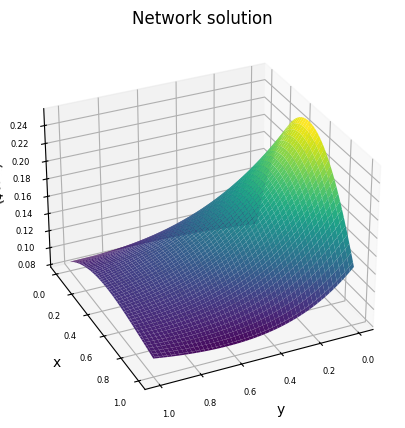

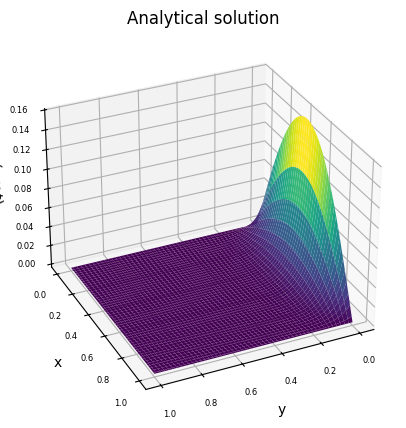

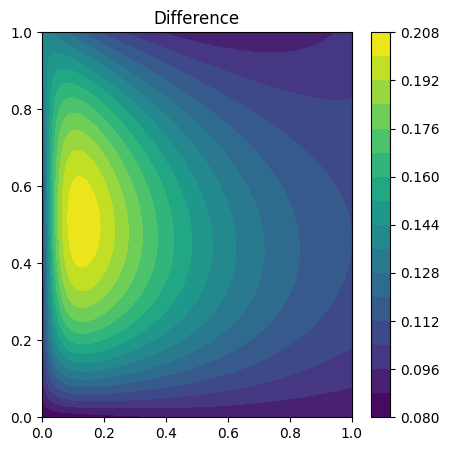

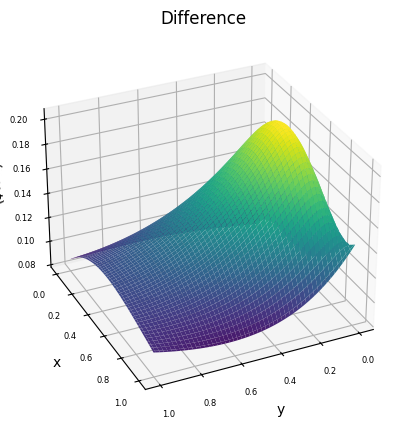

In [9]:
TFNetwork.plot_results(plots='all',time_idx=[5])

print('Final cost: %.5e' %TFNetwork.cost_history[-1])
print('Best cost : %.5e' %min(TFNetwork.cost_history))

### Prediction with `Adagrad`

In [11]:
gd_method = 'adagrad'

## Network initializtion
if test == 'wave2d' or test == 'diff2d':
    TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

    ## Setup of collocation tensor
    TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
else:
    TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

    ## Setup of collocation tensor
    TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)
TFNetwork.create_layers(lmbda=lmbda)

epoch = epoch

tf_net_timer = [time()]
TFNetwork.train_network(epochs=epoch,tol=1e-8)
tf_net_timer.append(time())

print('TensorFlow PINN-solver time: %.2f sec.' %(tf_net_timer[1]-tf_net_timer[0]))

Final cost = 1.12868e-01
TensorFlow PINN-solver time: 95.34 sec.


Final cost: 1.12868e-01
Best cost : 1.12868e-01


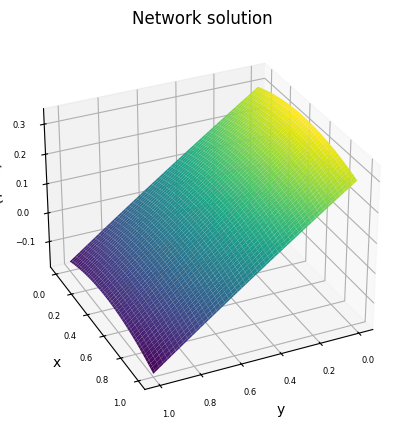

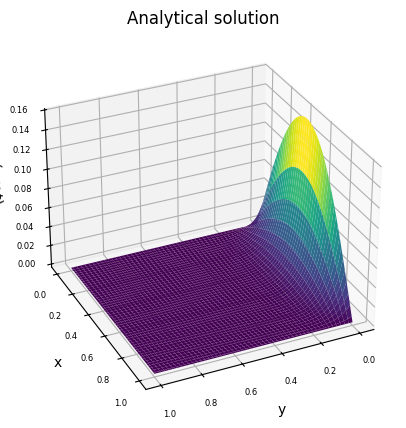

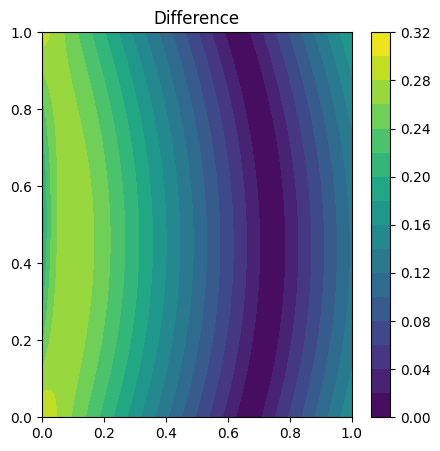

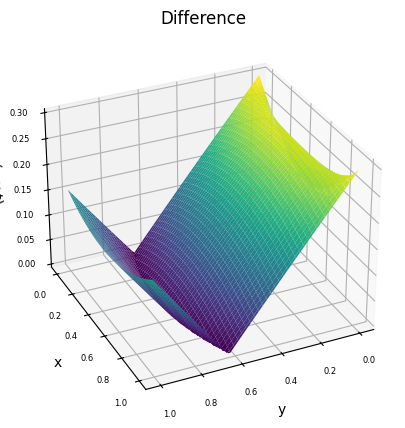

In [12]:
TFNetwork.plot_results(plots='all',time_idx=[5])

print('Final cost: %.5e' %TFNetwork.cost_history[-1])
print('Best cost : %.5e' %min(TFNetwork.cost_history))